In [1]:
%matplotlib notebook
from DataGenerator import * 
from network import LocalNet, LocalNetOutputMultiRuleModel
from BrainNet import BrainNet
from LocalNetBase import Options, UpdateScheme
import matplotlib.pyplot as plt
from train import train_local_rule, train_vanilla, train_given_rule
import numpy as np
from train import evaluate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4)

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Lambda(lambda x : x.flatten().double())])
trainset = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

testset = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)

In [93]:
options = Options(
                 gd_output = False,
                 gd_input = False,
                 use_graph_rule = True, 
                 use_input_rule = False,
                 use_output_rule = True,
                 gd_output_rule = False,
                 gd_graph_rule = True,
                 additive_rule = True)

scheme = UpdateScheme(
            cross_entropy_loss = True, 
            mse_loss = False, 
            update_misclassified = True,
            update_all_edges = False
        )

local_net = LocalNet(784, 10, num_v = 100, p = .5, cap = 50, rounds = 0, step_sz=1e-2, options = options, update_scheme = scheme)
# local_net.input_weights = torch.ones_like(local_net.input_weights).double()
# local_net.graph_weights = torch.ones_like(local_net.graph_weights).double()
# local_net.set_output_rule(torch.tensor([[-1, 1], [1, -1]]))
local_net.set_output_rule(torch.tensor([[-1, 1], [1, -1]]))
# local_net.set_rnn_rule(torch.tensor([[0.15, -0.12, 0.20, -0.06],
#                                      [0.44, 0.08, 0.47, -0.11],
#                                      [0.26, 0.43, 1.41, -0.77],
#                                      [0.19, -0.54, 0.16, -0.31]]))

losses = []
optimizer = torch.optim.Adam(local_net.parameters(), lr=1e-2, weight_decay = 0.01)
local_net.rule.detach().reshape(16, 16)

tensor([[ 0.7803,  0.9886, -0.6112,  1.7310, -0.7242,  0.7870,  0.4545,  0.4581,
         -1.0893, -0.6807, -0.4602,  0.0526, -0.4796,  0.3159,  1.1265,  0.3986],
        [-0.8096, -0.7319,  0.6772, -1.4320,  0.1725, -0.3537, -0.5178, -1.0124,
          1.0002,  1.1567,  1.5561, -0.2078,  0.0146, -0.0695,  0.6294, -1.3165],
        [-1.1028, -0.4310,  2.3873,  0.3228,  0.8246,  0.4661,  1.9818,  1.1587,
         -0.3125, -1.3558, -0.2346, -1.0303, -0.9985, -0.5305,  0.7147, -0.1906],
        [ 0.6772,  1.4189, -1.2097,  1.7252,  1.1301,  0.3751,  1.5695,  1.0631,
          1.6430,  0.8621, -0.5989, -2.3664, -0.9359, -0.5777,  0.0496,  0.0417],
        [-2.3534, -0.6881, -1.1857,  0.9374,  0.8594, -0.7962,  1.0144,  1.0012,
         -0.9105, -0.6119,  0.7736,  1.0765, -0.3487, -0.2760,  0.2863,  0.4135],
        [-0.2670,  0.8769, -0.5086,  0.0656, -0.3993,  1.2959, -1.1586, -2.1786,
         -0.8233, -1.5003, -0.3633, -0.0106, -0.2217, -0.9604, -0.4083, -1.2216],
        [-0.8203, -1.1

In [94]:
for i in range(20):
    for j, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        loss = local_net(inputs, labels, 10, 10, continue_=False)
        losses += [loss.item()]
        loss.backward()
        optimizer.step()
        if j % 100 == 0:
            print('Epoch {:d} Batch {:d}: {:.3f}'.format(i, j, np.median(losses[i*600 + j-100:i*600 + j+1])))
            local_net.step_sz *= 0.96

Epoch 0 Batch 0: 49985.061
Epoch 0 Batch 100: 68.994
Epoch 0 Batch 200: 31.037
Epoch 0 Batch 300: 25.028
Epoch 0 Batch 400: 27.324
Epoch 0 Batch 500: 27.694
Epoch 1 Batch 0: 23.196
Epoch 1 Batch 100: 29.524
Epoch 1 Batch 200: 17.459
Epoch 1 Batch 300: 17.654
Epoch 1 Batch 400: 13.506
Epoch 1 Batch 500: 11.855
Epoch 2 Batch 0: 10.643
Epoch 2 Batch 100: 8.595
Epoch 2 Batch 200: 7.757
Epoch 2 Batch 300: 7.060
Epoch 2 Batch 400: 5.326
Epoch 2 Batch 500: 5.121
Epoch 3 Batch 0: 5.191
Epoch 3 Batch 100: 4.028
Epoch 3 Batch 200: 4.190
Epoch 3 Batch 300: 3.728
Epoch 3 Batch 400: 3.735
Epoch 3 Batch 500: 3.136
Epoch 4 Batch 0: 2.894
Epoch 4 Batch 100: 2.569
Epoch 4 Batch 200: 2.413
Epoch 4 Batch 300: 2.443
Epoch 4 Batch 400: 1.987
Epoch 4 Batch 500: 1.738
Epoch 5 Batch 0: 1.570
Epoch 5 Batch 100: 1.372
Epoch 5 Batch 200: 1.438
Epoch 5 Batch 300: 1.256
Epoch 5 Batch 400: 1.108
Epoch 5 Batch 500: 1.150
Epoch 6 Batch 0: 1.174
Epoch 6 Batch 100: 1.000
Epoch 6 Batch 200: 1.075
Epoch 6 Batch 300: 1.04

KeyboardInterrupt: 

In [4]:
rule_2 = np.array([[0.15, -0.12, 0.20, -0.06], 
                   [0.44, 0.08, 0.47, -0.11], 
                   [0.26, 0.43, 1.41, -0.77], 
                   [0.19, -0.54, 0.16, -0.31]])

rule_4 = np.zeros((16, 16))
for i in range(16):
    for j in range(16):
        rule_4[i, j] = rule_2[i // 4, j//4] + rule_2[i % 8 // 2, j % 8 // 2] + rule_2[i % 4, j % 4]

In [3]:
options = Options(
                 gd_output = False,
                 gd_input = False,
                 use_graph_rule = False, 
                 use_input_rule = False,
                 use_output_rule = True,
                 gd_output_rule = False,
                 gd_graph_rule = False,
                 additive_rule = True)

scheme = UpdateScheme(
            cross_entropy_loss = True, 
            mse_loss = False, 
            update_misclassified = True,
            update_all_edges = False
        )

local_net = LocalNet(784, 10, num_v = 1000, p = .5, cap = 500, rounds = 0, step_sz=1e-2, options = options, update_scheme = scheme)
local_net.input_weights = torch.ones_like(local_net.input_weights).double()
# local_net.graph_weights = torch.ones_like(local_net.graph_weights).double()
local_net.set_output_rule(torch.tensor([[-1, 1], [1, -1]]))
# local_net.set_output_rule(torch.tensor([[-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1]]))
# local_net.set_rnn_rule(rule)

losses = []

In [4]:
for i in range(20):
    for j, data in enumerate(trainloader):
        if j == 0:
            local_correct = 0
            with torch.no_grad():
                for inputs, labels in testloader:
                    outputs = local_net.forward_pass(inputs)
                    local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
            print('Test Accuracy: {:.3f}%'.format(local_correct / len(testset) * 100))
        inputs, labels = data
        if i == 0 and j == 0:
            continue_ = False
        else:
            continue_ = True
        loss = local_net(inputs, labels, 1, 1, continue_=True)
        losses += [loss.item()]
        if j % 100 == 0:
            print('Epoch {:d} Batch {:d}: {:.3f}'.format(i, j, np.median(losses[i*600 + j-100:i*600 + j+1])))
            local_net.step_sz *= 0.95

Test Accuracy: 10.290%
Epoch 0 Batch 0: 627.425
Epoch 0 Batch 100: 72.829
Epoch 0 Batch 200: 44.104
Epoch 0 Batch 300: 36.976
Epoch 0 Batch 400: 33.373
Epoch 0 Batch 500: 25.547
Test Accuracy: 89.390%
Epoch 1 Batch 0: 26.183
Epoch 1 Batch 100: 19.030
Epoch 1 Batch 200: 18.784
Epoch 1 Batch 300: 16.382
Epoch 1 Batch 400: 15.772
Epoch 1 Batch 500: 15.528
Test Accuracy: 90.530%
Epoch 2 Batch 0: 18.208
Epoch 2 Batch 100: 10.953
Epoch 2 Batch 200: 14.395
Epoch 2 Batch 300: 10.119
Epoch 2 Batch 400: 14.364
Epoch 2 Batch 500: 13.556
Test Accuracy: 90.440%
Epoch 3 Batch 0: 12.999
Epoch 3 Batch 100: 11.409
Epoch 3 Batch 200: 9.025


KeyboardInterrupt: 

In [10]:
options = Options(
                 gd_output = False,
                 gd_input = False,
                 use_graph_rule = True, 
                 use_input_rule = False,
                 use_output_rule = True,
                 gd_output_rule = False,
                 gd_graph_rule = False,
                 additive_rule = True)

scheme = UpdateScheme(
            cross_entropy_loss = True, 
            mse_loss = False, 
            update_misclassified = True,
            update_all_edges = False
        )

local_net = LocalNet(784, 10, num_v = 500, p = .5, cap = 250, rounds = 3, step_sz=1e-2, options = options, update_scheme = scheme)
# local_net.input_weights = torch.ones_like(local_net.input_weights).double()
# local_net.graph_weights = torch.ones_like(local_net.graph_weights).double()
# local_net.set_output_rule(torch.tensor([[-1, 1], [1, -1]]))
local_net.set_output_rule(torch.tensor([[-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1], [-1, 1], [1, -1]]))
local_net.set_rnn_rule(torch.tensor(rule_4))
# local_net.set_rnn_rule(rule)

losses = []

In [11]:
for i in range(20):
    for j, data in enumerate(trainloader):
        if j == 0:
            local_correct = 0
            with torch.no_grad():
                for inputs, labels in testloader:
                    outputs = local_net.forward_pass(inputs)
                    local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
            print('Test Accuracy: {:.3f}%'.format(local_correct / len(testset) * 100))
        inputs, labels = data
        if i == 0 and j == 0:
            continue_ = False
        else:
            continue_ = True
        loss = local_net(inputs, labels, 1, 1, continue_=True)
        losses += [loss.item()]
        if j % 100 == 0:
            print('Epoch {:d} Batch {:d}: {:.3f}'.format(i, j, np.median(losses[i*600 + j-100:i*600 + j+1])))
            local_net.step_sz *= 0.96

Test Accuracy: 8.310%
Epoch 0 Batch 0: 8802957.343
Epoch 0 Batch 100: 58512442082.454
Epoch 0 Batch 200: 259296814388.058
Epoch 0 Batch 300: 526543465096.718
Epoch 0 Batch 400: 831656271437.358
Epoch 0 Batch 500: 1294371080090.808
Test Accuracy: 73.570%
Epoch 1 Batch 0: 1681635541553.612
Epoch 1 Batch 100: 1838175887172.150
Epoch 1 Batch 200: 2392750582759.803
Epoch 1 Batch 300: 2771604790436.031
Epoch 1 Batch 400: 3424641413528.264
Epoch 1 Batch 500: 3756564278121.226
Test Accuracy: 74.260%
Epoch 2 Batch 0: 4250039727615.484
Epoch 2 Batch 100: 4158757218741.047
Epoch 2 Batch 200: 5324563066044.432


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


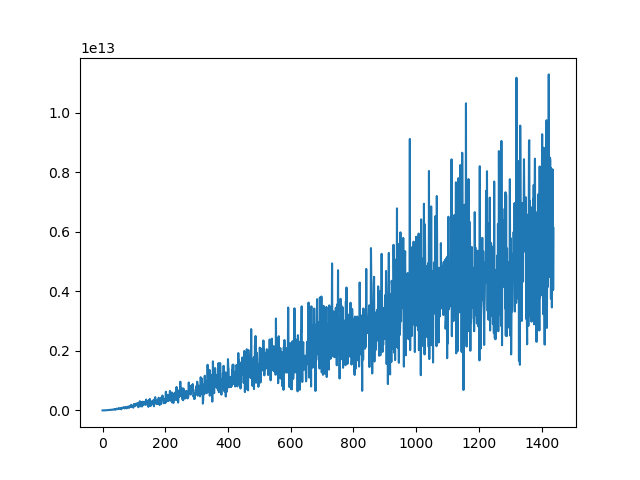

In [12]:
fig, ax = plt.subplots()
ax.plot(losses)

In [5]:
local_correct = 0

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = local_net.forward_pass(inputs)
        local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
print('Local Net Test Accuracy: {:.3f}%'.format(local_correct / len(testset) * 100))

Local Net Test Accuracy: 91.020%


<IPython.core.display.Javascript object>


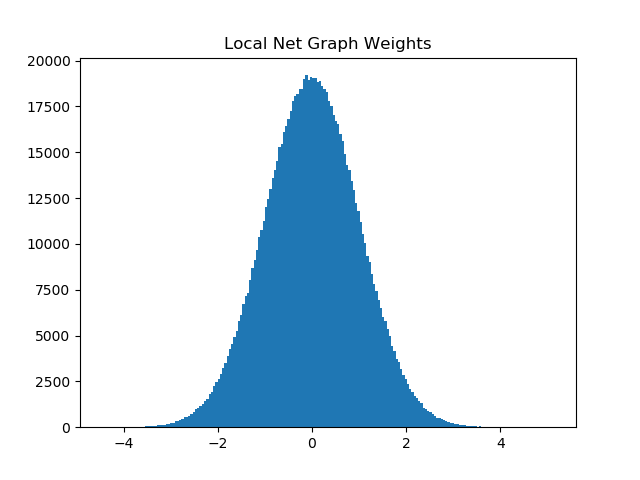

Text(0.5, 1.0, 'Local Net Graph Weights')

In [6]:
fig, ax = plt.subplots()
ax.hist(local_net.graph_weights.numpy().flatten(), bins=200)
ax.set_title('Local Net Graph Weights')

<IPython.core.display.Javascript object>


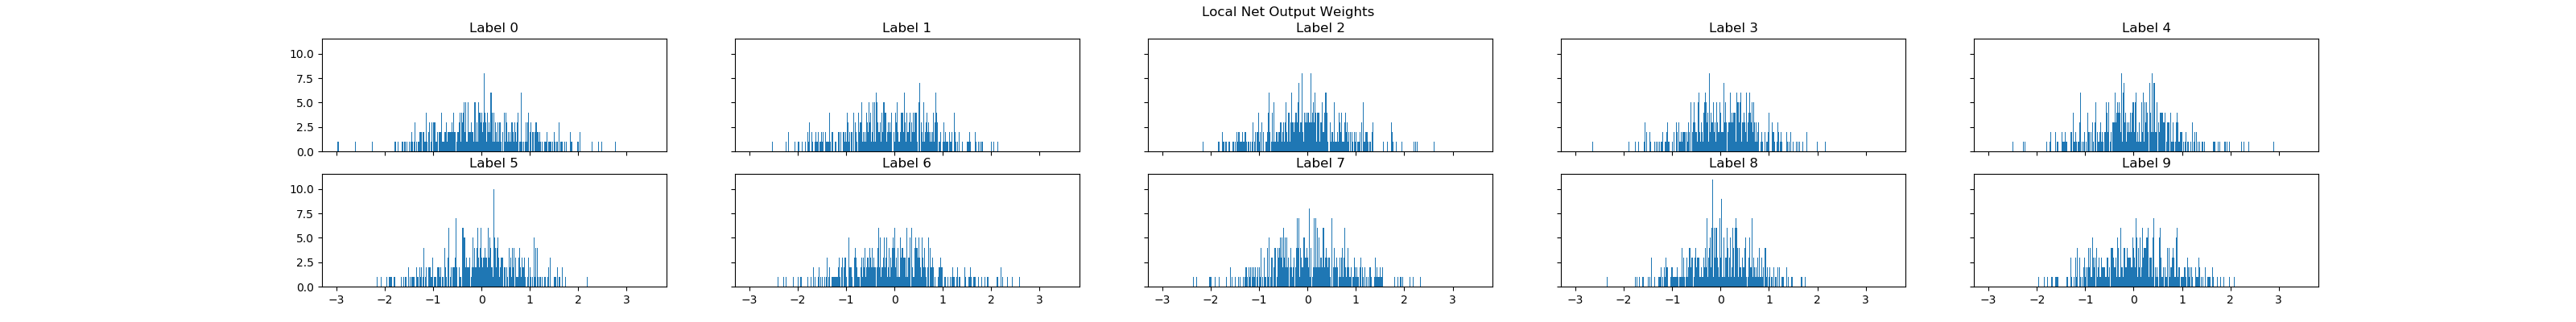

Text(0.5, 0.98, 'Local Net Output Weights')

In [7]:
weights = local_net.output_weights.numpy()
fig, axes = plt.subplots(2, 5, figsize=(32, 4), sharex=True, sharey=True)
for i in range(2):
    for j, ax in enumerate(axes[i]):
        axes[i, j].hist(weights[i*5 + j], bins=1000, range=(weights.min(), weights.max()))
        axes[i, j].set_title('Label {}'.format(i*5 + j))
fig.suptitle('Local Net Output Weights')

In [16]:
for i in range(10):
    print(np.count_nonzero(np.histogram(weights[i], bins=1000, range=(-3, 3))[0]))

252
268
235
216
225
247
229
259
242
211


In [10]:
gd_net = BrainNet(784, 10, num_v = 1000, p = .5, cap = 500, rounds = 3, gd_output = True, gd_graph=True)
gd_net.input_layer = local_net.input_layer
gd_net.input_weights = local_net.input_weights
# gd_net.graph_weights = local_net.graph_weights
gd_net.graph = local_net.graph
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gd_net.parameters(), lr=1e-2)
losses = []

In [11]:
for i in range(20):
    for j, data in enumerate(trainloader):
        if j == 0:
            local_correct = 0
            with torch.no_grad():
                for inputs, labels in testloader:
                    outputs = gd_net.forward_pass(inputs)
                    local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
            print('Test Accuracy: {:.3f}%'.format(local_correct / len(testset) * 100))
        inputs, labels = data
        optimizer.zero_grad()
        outputs = gd_net.forward_pass(inputs)
        loss = criterion(outputs, labels)
        losses += [loss.item()]
        loss.backward()
        optimizer.step()
        if j % 100 == 0:
            print('Epoch {:d} Batch {:d}: {:.3f}'.format(i, j, np.median(losses[i*600 + j-100:i*600 + j+1])))

Test Accuracy: 10.270%
Epoch 0 Batch 0: 27884757.343
Epoch 0 Batch 100: 483806.024
Epoch 0 Batch 200: 227434.505
Epoch 0 Batch 300: 174776.196
Epoch 0 Batch 400: 136372.358
Epoch 0 Batch 500: 120577.788
Test Accuracy: 86.330%
Epoch 1 Batch 0: 96663.620
Epoch 1 Batch 100: 86318.125
Epoch 1 Batch 200: 78649.034
Epoch 1 Batch 300: 71967.114
Epoch 1 Batch 400: 59313.716
Epoch 1 Batch 500: 60476.905
Test Accuracy: 84.530%
Epoch 2 Batch 0: 55449.246
Epoch 2 Batch 100: 39780.608
Epoch 2 Batch 200: 49330.376
Epoch 2 Batch 300: 46332.476
Epoch 2 Batch 400: 39666.605


KeyboardInterrupt: 

In [12]:
gd_correct = 0

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = gd_net.forward_pass(inputs)
        gd_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
print('GD Net Test Accuracy: {:.3f}%'.format(gd_correct / len(testset) * 100))

GD Net Test Accuracy: 87.490%


<IPython.core.display.Javascript object>


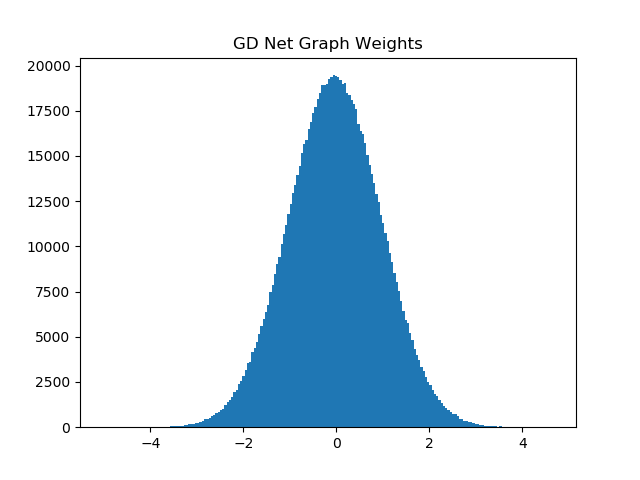

Text(0.5, 1.0, 'GD Net Graph Weights')

In [13]:
fig, ax = plt.subplots()
ax.hist(gd_net.graph_weights.detach().numpy().flatten(), bins=200)
ax.set_title('GD Net Graph Weights')

<IPython.core.display.Javascript object>


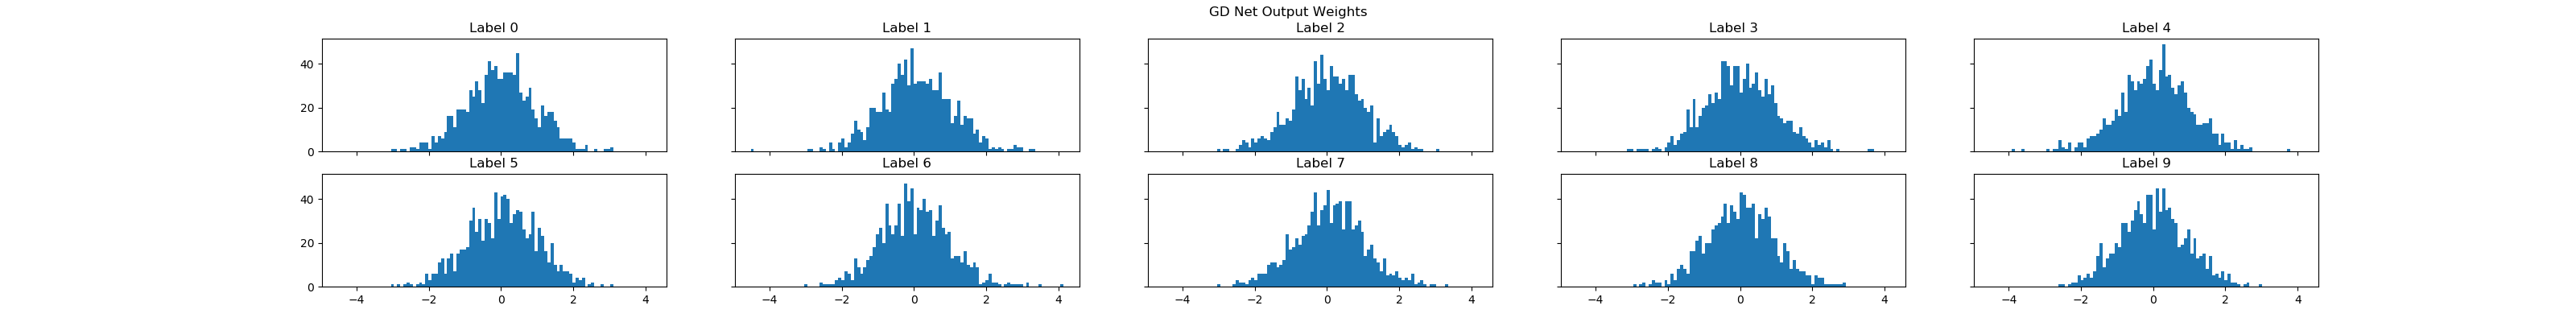

Text(0.5, 0.98, 'GD Net Output Weights')

In [14]:
weights = gd_net.output_weights.detach().numpy()
fig, axes = plt.subplots(2, 5, figsize=(32, 4), sharex=True, sharey=True)
for i in range(2):
    for j, ax in enumerate(axes[i]):
        axes[i, j].hist(weights[i*5 + j], bins=100, range=(weights.min(), weights.max()))
        axes[i, j].set_title('Label {}'.format(i*5 + j))
fig.suptitle('GD Net Output Weights')

In [15]:
for i in range(10):
    print(np.count_nonzero(np.histogram(weights[i], bins=1000, range=(-max(-weights.min(), weights.max()), max(-weights.min(), weights.max())))[0]))

394
388
395
391
397
389
382
395
377
383


In [16]:
from AdversarialExamples import adversarial_example

idx = np.full(10, -1, dtype=int)
for i, data in enumerate(testset):
    input, label = data
    with torch.no_grad():
        local_pred = local_net.forward_pass(input.reshape(1, -1)).argmax()
        gd_pred = gd_net.forward_pass(input.reshape(1, -1)).argmax()
        if local_pred == label and gd_pred == label and idx[label] < 0:
            idx[label] = i
    if np.all(idx >= 0):
        print('Appropriate samples found')
        break

Appropriate samples found


In [17]:
idx

array([ 3,  2,  1, 30,  4, 15, 21,  0, 61,  7])

In [18]:
inputs = []
for i in idx:
    data = testset[i]
    input, label = data
    inputs += [input.reshape(1, -1)]
inputs = torch.cat(inputs, dim=0)
print(inputs.shape)

torch.Size([10, 784])


In [19]:
local_adv_ex = torch.Tensor(10, 10, 784)
gd_adv_ex = torch.Tensor(10, 10, 784)
for i in range(10):
    for j in range(10):
        print(j)
        if i == j:
            local_adv_ex[i, j] = inputs[i].squeeze()
            gd_adv_ex[i, j] = inputs[i].squeeze()
        else:
            local_adv_ex[i, j] = adversarial_example(inputs[i].reshape(1, -1), torch.tensor([j], dtype=torch.long), local_net.forward_pass, lr=1e-3)
            gd_adv_ex[i, j] = adversarial_example(inputs[i].reshape(1, -1), torch.tensor([j], dtype=torch.long), gd_net.forward_pass, lr=1e-2)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


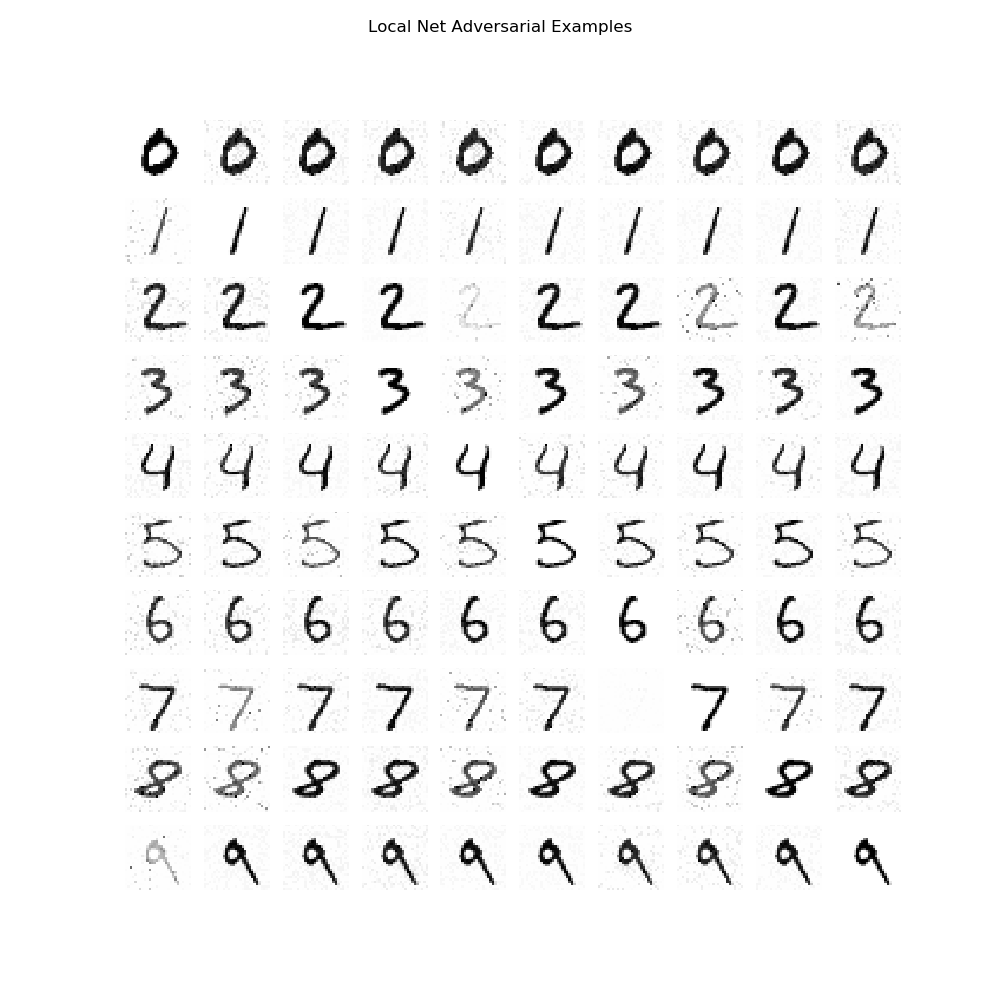

Text(0.5, 0.98, 'Local Net Adversarial Examples')

In [24]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j, ax in enumerate(axes[i]):
        ax.imshow(local_adv_ex[i, j].detach().reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
        ax.set_axis_off()
        
fig.suptitle('Local Net Adversarial Examples')

<IPython.core.display.Javascript object>


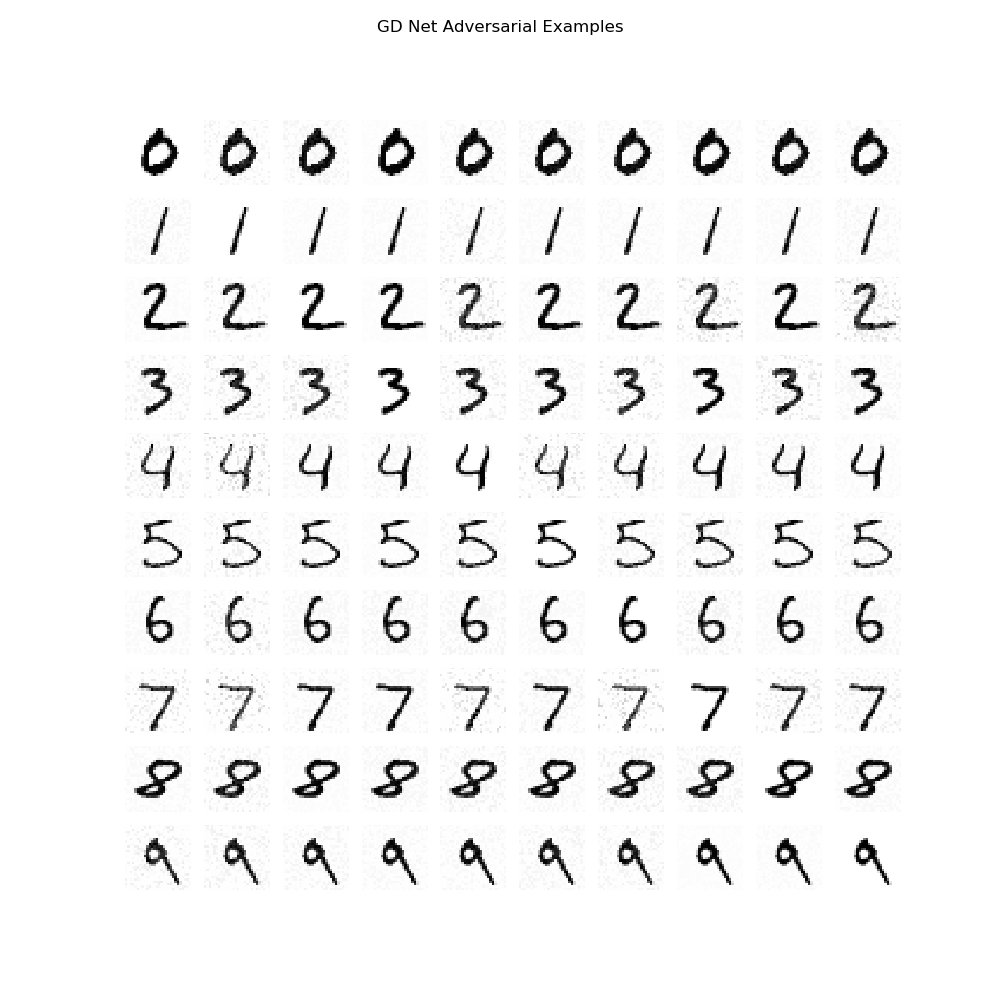

Text(0.5, 0.98, 'GD Net Adversarial Examples')

In [23]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j, ax in enumerate(axes[i]):
        ax.imshow(gd_adv_ex[i, j].detach().reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
        ax.set_axis_off()
        
fig.suptitle('GD Net Adversarial Examples')

<IPython.core.display.Javascript object>


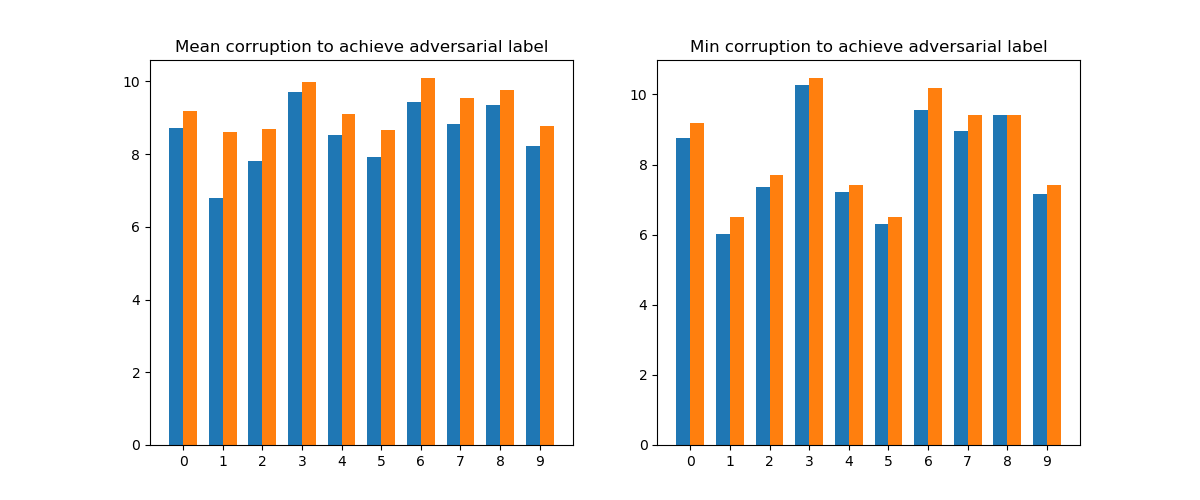

Text(0.5, 1.0, 'Min corruption to achieve adversarial label')

In [83]:
local_mag = torch.norm(inputs.reshape(1, 10, -1) - local_adv_ex.detach(), dim=-1)
gd_mag = torch.norm(inputs.reshape(1, 10, -1) - gd_adv_ex.detach(), dim=-1)

width = 0.35
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(np.arange(10) - width/2, local_mag.mean(dim=0), width=width, label='Local')
axes[0].bar(np.arange(10) + width/2, gd_mag.mean(dim=0), width=width, label='GD')
axes[0].set_xticks(np.arange(10))
axes[0].set_title('Mean corruption to achieve adversarial label')

axes[1].bar(np.arange(10) - width/2, (local_mag + torch.eye(10) * 100).min(dim=0)[0], width=width, label='Local')
axes[1].bar(np.arange(10) + width/2, (gd_mag + torch.eye(10) * 100).min(dim=0)[0], width=width, label='GD')
axes[1].set_xticks(np.arange(10))
axes[1].set_title('Min corruption to achieve adversarial label')

In [4]:
meta_model = LocalNetOutputMultiRuleModel(784, 10, num_v = 500, p = .5, cap = 250, rounds = 0, step_sz=1e-5, options = options)
optimizer = torch.optim.Adam(meta_model.output_rule_model.parameters(), lr=1e-3)
losses = []

/home/max/Projects/Learning Plasticity Rules/network.py:229: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629401553/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  self.edges = (self.graph > 0).nonzero()


In [5]:
for i in range(5):
    for j, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        if i == 0 and j == 0:
            continue_ = False
        else:
            continue_ = True
        loss = meta_model(inputs, labels, 1, 1)
        loss.backward()
        optimizer.step()
        losses += [loss.item()]
        if j % 100 == 0:
            print('{:d} {:d}: {:.3f}'.format(i, j, loss.item()))

0 0: 2.303
0 100: 2.262
0 200: 1.816


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


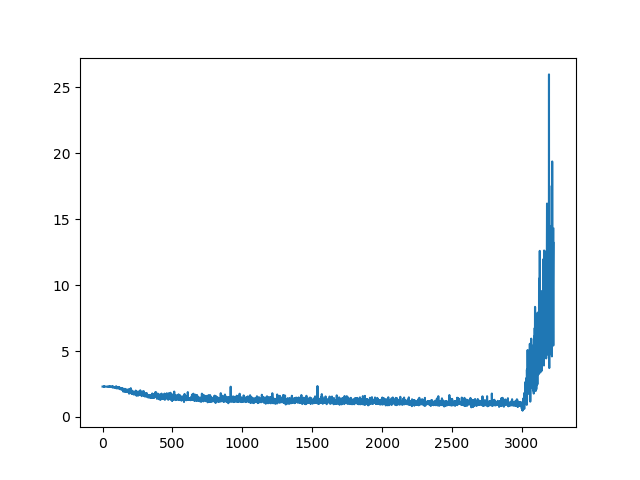

In [70]:
fig, ax = plt.subplots()
ax.plot(losses)

In [67]:
local_correct = 0

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = meta_model.forward_pass(inputs)
        local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
print('Local Net Test Accuracy: {:.3f}%'.format(local_correct / len(testset) * 100))

Local Net Test Accuracy: 67.050%


In [69]:
for i in range(15):
    for j, data in enumerate(trainloader):
        inputs, labels = data
#         if i == 0 and j == 0:
#             continue_ = False
#         else:
        continue_ = True
        loss = meta_model(inputs, labels, 1, 1, continue_=False)
        losses += [loss.item()]
        if j % 100 == 0:
            print('{:d} {:d}: {:.3f}'.format(i, j, loss.item()))

0 0: 0.646
0 100: 1.968
0 200: 9.661


KeyboardInterrupt: 

In [213]:
np.savez_compressed('models/localnet_mnist_rnn_outputrule.npz', 
                    input_weights=local_net.input_weights.numpy(), 
                    graph_weights=local_net.graph_weights.numpy(),
                    output_weights=local_net.output_weights.numpy())

In [10]:
np.savez_compressed('models/gdnet_mnist_rnn_outputrule.npz', 
                    input_weights=gd_net.input_weights.detach().numpy(), 
                    graph_weights=gd_net.graph_weights.detach().numpy(),
                    output_weights=gd_net.output_weights.detach().numpy())